In [ ]:
#!/usr/bin/env python3
import json
import re
import argparse
import pandas as pd
import matplotlib.pyplot as plt

def extract_text_from_ipynb(ipynb_filename):
    """
    Extracts all text outputs (stdout and stderr) from code cells of a Jupyter notebook (.ipynb).
    Returns a single large text string.
    """
    with open(ipynb_filename, 'r', encoding='utf-8') as f:
        notebook = json.load(f)

    output_texts = []

    for cell in notebook.get('cells', []):
        if cell.get('cell_type') != 'code':
            continue
        for output in cell.get('outputs', []):
            if output.get('output_type') == 'stream':
                text = output.get('text', '')
                if isinstance(text, list):
                    text = ''.join(text)
                output_texts.append(text)

    return ''.join(output_texts)
def parse_metrics_from_text(text, epochs_per_cycle=50):
    """
    More robust parser: goes line-by-line instead of using a big regex.
    Handles missing/misordered outputs better.
    """
    lines = text.splitlines()
    rows = []
    current_epoch = None
    buffer = []

    for line in lines:
        epoch_header = re.match(r'=== Epoch (\d+)/\d+ ===', line)
        metrics_header = re.match(r'Epoch (\d+) Metrics:', line)

        if epoch_header:
            current_epoch = int(epoch_header.group(1))
            buffer = []  # Clear buffer for safety
            continue

        if metrics_header:
            # Start of metrics block
            if current_epoch is None:
                # Safety check: somehow metrics found without epoch
                continue
            buffer = []  # start fresh metrics buffer
            continue

        if current_epoch is not None:
            # If we're inside a metrics block, collect the lines
            buffer.append(line.strip())

            # A blank line means end of metrics block
            if line.strip() == "":
                # Process the buffered metrics
                metrics = {
                    'Reported_Epoch': current_epoch
                }
                for metric_line in buffer:
                    m = re.match(r'([^:]+):\s*([\d\.]+)', metric_line)
                    if m:
                        key = m.group(1).strip().replace(' ', '_')
                        val = float(m.group(2))
                        metrics[key] = val

                # Compute global epoch
                idx = len(rows)
                cycle_idx = idx // epochs_per_cycle
                global_epoch = cycle_idx * epochs_per_cycle + current_epoch
                metrics['Global_Epoch'] = global_epoch

                rows.append(metrics)

                # Reset state
                current_epoch = None
                buffer = []

    df = pd.DataFrame(rows)
    return df.sort_values('Global_Epoch').reset_index(drop=True)




In [ ]:
# Hardcode notebook name
NOTEBOOK_FILENAME = "cycle_GAN_train4.ipynb"
EPOCHS_PER_CYCLE = 50

# 1. Extract all text outputs from the notebook
text = extract_text_from_ipynb(NOTEBOOK_FILENAME)

# 2. Parse metrics from the extracted text
df = parse_metrics_from_text(text, epochs_per_cycle=EPOCHS_PER_CYCLE)
print("\nParsed metrics (first 10 rows):")
print(df.head(10).to_string(index=False))
print(df.shape)





Parsed metrics (first 10 rows):
 Reported_Epoch  Loss_DV  Loss_DS  Loss_adv_vocal  Loss_adv_speech  Loss_Cycle_Vocal  Loss_Cycle_Speech  Loss_Identity_Vocal  Loss_Identity_Speech  Grad_Norm_DV  Grad_Norm_DS  Grad_Norm_GV  Grad_Norm_GS  num_DV_updates  num_DS_updates  Global_Epoch
              1   0.7512   0.7336          0.1735           0.1649           23.5501            26.3075              30.0653               29.2166        0.7523        0.9174        0.0065        0.0046            15.0            14.0             1
              2   0.7515   0.5876          0.1154           0.1992            9.1575            10.5017              15.4101               14.6025        0.3659        0.0000        0.0060        0.0075            15.0             0.0             2
              3   0.7417   0.6545          0.1087           0.1538            7.3917             8.8523              10.1300               11.9215        0.1464        1.3821        0.0035        0.0041            16.0  

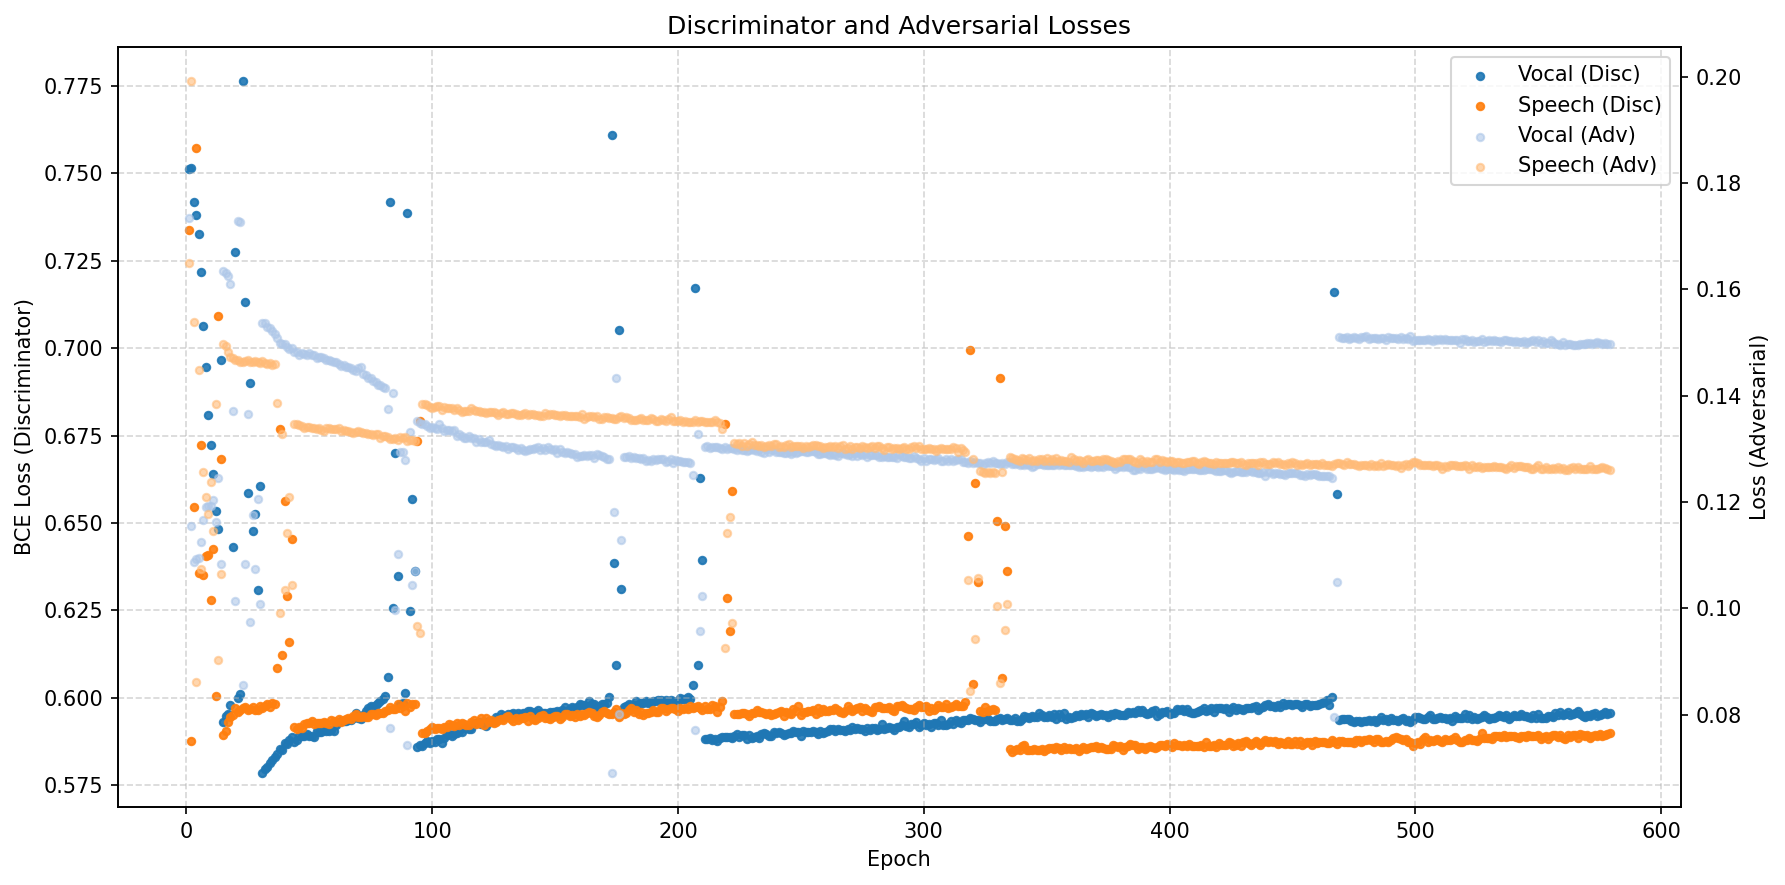

<Figure size 640x480 with 0 Axes>

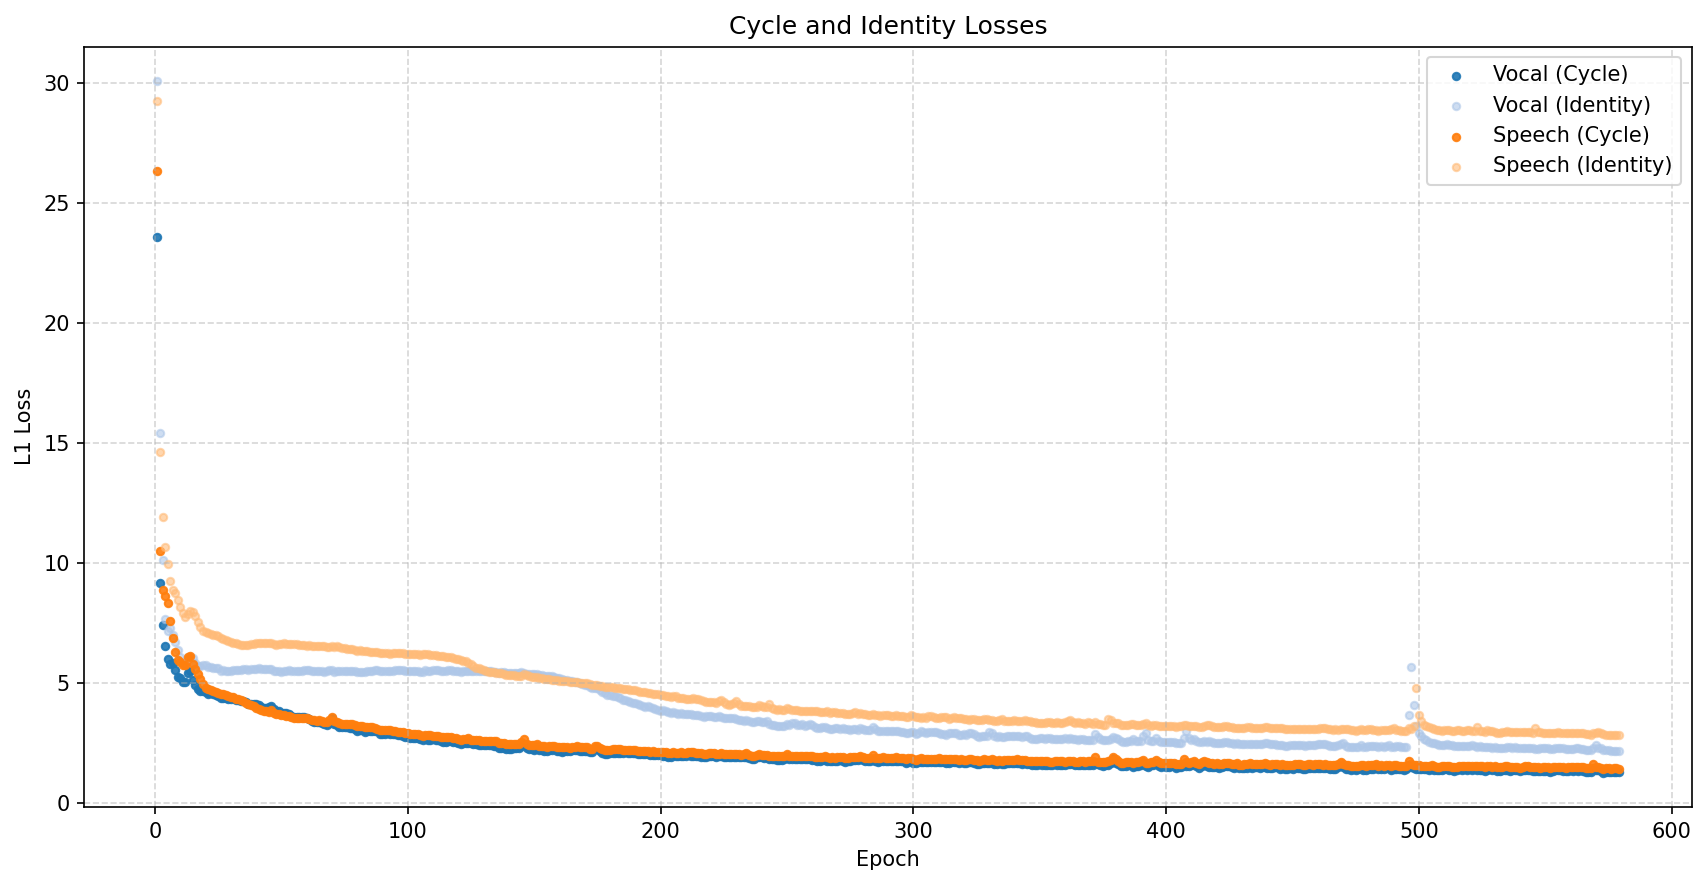

<Figure size 640x480 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt

marker_size = 50

def plot_discriminator_adversarial(df):
    """Dual-axis plot: Discriminator Loss vs Adversarial Loss"""
    marker_size_main = marker_size
    marker_size_pale = marker_size
    dpi = 150
    alpha_main = 0.9
    alpha_pale = 0.6

    colors = {
        'Vocal': '#1f77b4',   # vivid blue
        'Speech': '#ff7f0e',  # vivid orange
    }
    pale_colors = {
        'Vocal': '#aec7e8',   # pale blue
        'Speech': '#ffbb78',  # pale orange
    }

    fig, ax1 = plt.subplots(figsize=(12, 6), dpi=dpi)
    ax2 = ax1.twinx()

    for label in ['Vocal', 'Speech']:
        ax1.scatter(df['Global_Epoch'], df[f'Loss_D{"V" if label=="Vocal" else "S"}'], 
                    label=f'{label} (Disc)', color=colors[label], s=marker_size_main, marker='.', alpha=alpha_main)
        ax2.scatter(df['Global_Epoch'], df[f'Loss_adv_{label.lower()}'], 
                    label=f'{label} (Adv)', color=pale_colors[label], s=marker_size_pale, marker='.', alpha=alpha_pale)

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("BCE Loss (Discriminator)")
    ax2.set_ylabel("Loss (Adversarial)")
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Combine legends
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

    plt.title("Discriminator and Adversarial Losses")
    plt.tight_layout()
    plt.show()
    plt.savefig("disc_adv_losses.png", dpi=dpi, bbox_inches='tight', transparent=True)


def plot_cycle_identity(df):
    """Single-axis plot: Cycle Loss and Identity Loss, using the same colors as the discriminator plot."""
    marker_size_cycle = marker_size
    marker_size_identity = marker_size
    alpha_cycle = 0.9
    alpha_identity = 0.6
    dpi = 150

    # Same colors as in the other plot
    vivid_colors = {
        'Vocal': '#1f77b4',   # vivid blue
        'Speech': '#ff7f0e',  # vivid orange
    }
    pale_colors = {
        'Vocal': '#aec7e8',   # pale blue
        'Speech': '#ffbb78',  # pale orange
    }

    fig, ax = plt.subplots(figsize=(11.5, 6), dpi=dpi)

    for label in ['Vocal', 'Speech']:
        ax.scatter(df['Global_Epoch'], df[f'Loss_Cycle_{label}'],
                   label=f'{label} (Cycle)', color=vivid_colors[label],
                   s=marker_size_cycle, marker='.', alpha=alpha_cycle)
        ax.scatter(df['Global_Epoch'], df[f'Loss_Identity_{label}'],
                   label=f'{label} (Identity)', color=pale_colors[label],
                   s=marker_size_identity, marker='.', alpha=alpha_identity)

    ax.set_xlabel("Epoch")
    ax.set_ylabel("L1 Loss")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='upper right')
    plt.title("Cycle and Identity Losses")
    plt.tight_layout()
    plt.show()
    plt.savefig("cycle_identity_losses.png", dpi=dpi, bbox_inches='tight', transparent=True)


plot_discriminator_adversarial(df)
plot_cycle_identity(df)
